In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import os

# Load all NetCDF variables
def load_all_variables(nc_dir):
    nc_paths = [os.path.join(dp, f) for dp, _, files in os.walk(nc_dir) for f in files if f.endswith(".nc")]
    ds = xr.open_mfdataset(nc_paths, combine='by_coords')
    df = ds.to_dataframe().reset_index()
    df['time'] = pd.to_datetime(df['time'], unit='s', origin='unix').dt.tz_localize("UTC").dt.tz_convert("America/Chicago")
    return df

# Add time-based columns
def add_temporal_columns(df):
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    df['month'] = df['time'].dt.month
    df['doy'] = df['time'].dt.dayofyear
    df['weekday'] = df['time'].dt.weekday
    df['is_weekend'] = df['weekday'] >= 5
    return df

# Assign season labels
def assign_season(df):
    df['season'] = 'Other'
    df.loc[df['month'].isin([12, 1, 2]), 'season'] = 'Winter'
    df.loc[df['month'].isin([3, 4, 5]), 'season'] = 'Spring'
    df.loc[df['month'].isin([6, 7, 8]), 'season'] = 'Summer'
    df.loc[df['month'].isin([9, 10, 11]), 'season'] = 'Fall'
    return df

# Clean using QC flags
def clean_by_qc_flags(df, qc_map):
    dfc = df.copy()
    for var, qc_var in qc_map.items():
        if var in dfc.columns and qc_var in dfc.columns:
            dfc.loc[dfc[qc_var] > 1, var] = np.nan
    return dfc

# Compute z/L and apply u* threshold
def compute_stability(df, ustar_thresh=0.2, z=10.0):
    dfc = df[df['u*'] >= ustar_thresh].copy()
    dfc['inv_L'] = 1.0 / dfc['L']
    dfc.loc[~np.isfinite(dfc['inv_L']), 'inv_L'] = np.nan
    dfc['z_over_L'] = z * dfc['inv_L']
    return dfc

# Remove outliers via IQR
def remove_outliers_iqr(df, variables, k=1.5):
    dfc = df.copy()
    for var in variables:
        if var in dfc.columns:
            Q1 = dfc[var].quantile(0.25)
            Q3 = dfc[var].quantile(0.75)
            IQR = Q3 - Q1
            lower, upper = Q1 - k * IQR, Q3 + k * IQR
            dfc.loc[(dfc[var] < lower) | (dfc[var] > upper), var] = np.nan
    return dfc


In [3]:
# Path to your data
data_path = "/Users/bhupendra/projects/crocus/data/flux_data/data/netcdf/resnc/"

# Load all variables
df = load_all_variables(data_path)
df = add_temporal_columns(df)
df = assign_season(df)

# Clean by QC flags
qc_mapping = {
    'H': 'qc_H',
    'LE': 'qc_LE',
    'co2_flux': 'qc_co2_flux',
    'h2o_flux': 'qc_h2o_flux',
    'Tau': 'qc_Tau'
}
df = clean_by_qc_flags(df, qc_mapping)

# Filter by u* and compute z/L
df = compute_stability(df)

# Variables to use for clustering
cluster_vars = ['air_temperature', 'h2o_mixing_ratio', 'u*', 'z_over_L']

# Remove outliers using IQR
df = remove_outliers_iqr(df, cluster_vars)

# Final cleaned set for clustering
df_cluster_ready = df.dropna(subset=cluster_vars)

# Preview
df_cluster_ready[cluster_vars + ['time']].head()


,air_temperature,h2o_mixing_ratio,u*,z_over_L,time
0,291.055,8.98725,0.483986,-0.061616,2024-06-30 19:30:00-05:00
1,290.783,9.11061,0.512172,-0.014316,2024-06-30 20:00:00-05:00
2,290.194,9.63334,0.495518,0.008883,2024-06-30 20:30:00-05:00
3,290.057,10.27060,0.462451,0.010859,2024-06-30 21:00:00-05:00
4,289.728,11.75690,0.287325,-0.015816,2024-06-30 21:30:00-05:00


In [6]:
# Install MiniSom if needed
#!pip install minisom

from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Select features for SOM
cluster_vars = ['air_temperature', 'h2o_mixing_ratio', 'u*', 'z_over_L']
df_som_ready = df.dropna(subset=cluster_vars).copy()

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_som_ready[cluster_vars])

# Train SOM (e.g., 3x2 grid)
som = MiniSom(x=2, y=3, input_len=len(cluster_vars), sigma=1.0, learning_rate=0.5, random_seed=42)
som.train_random(X_scaled, num_iteration=1000)

# Assign cluster based on winner neuron
win_map = np.array([som.winner(x) for x in X_scaled])
labels = [f"R{a*3 + b + 1}" for a, b in win_map]  # Regime labels

# Create new DataFrame
df_som = df_som_ready.copy()
df_som['som_regime'] = labels


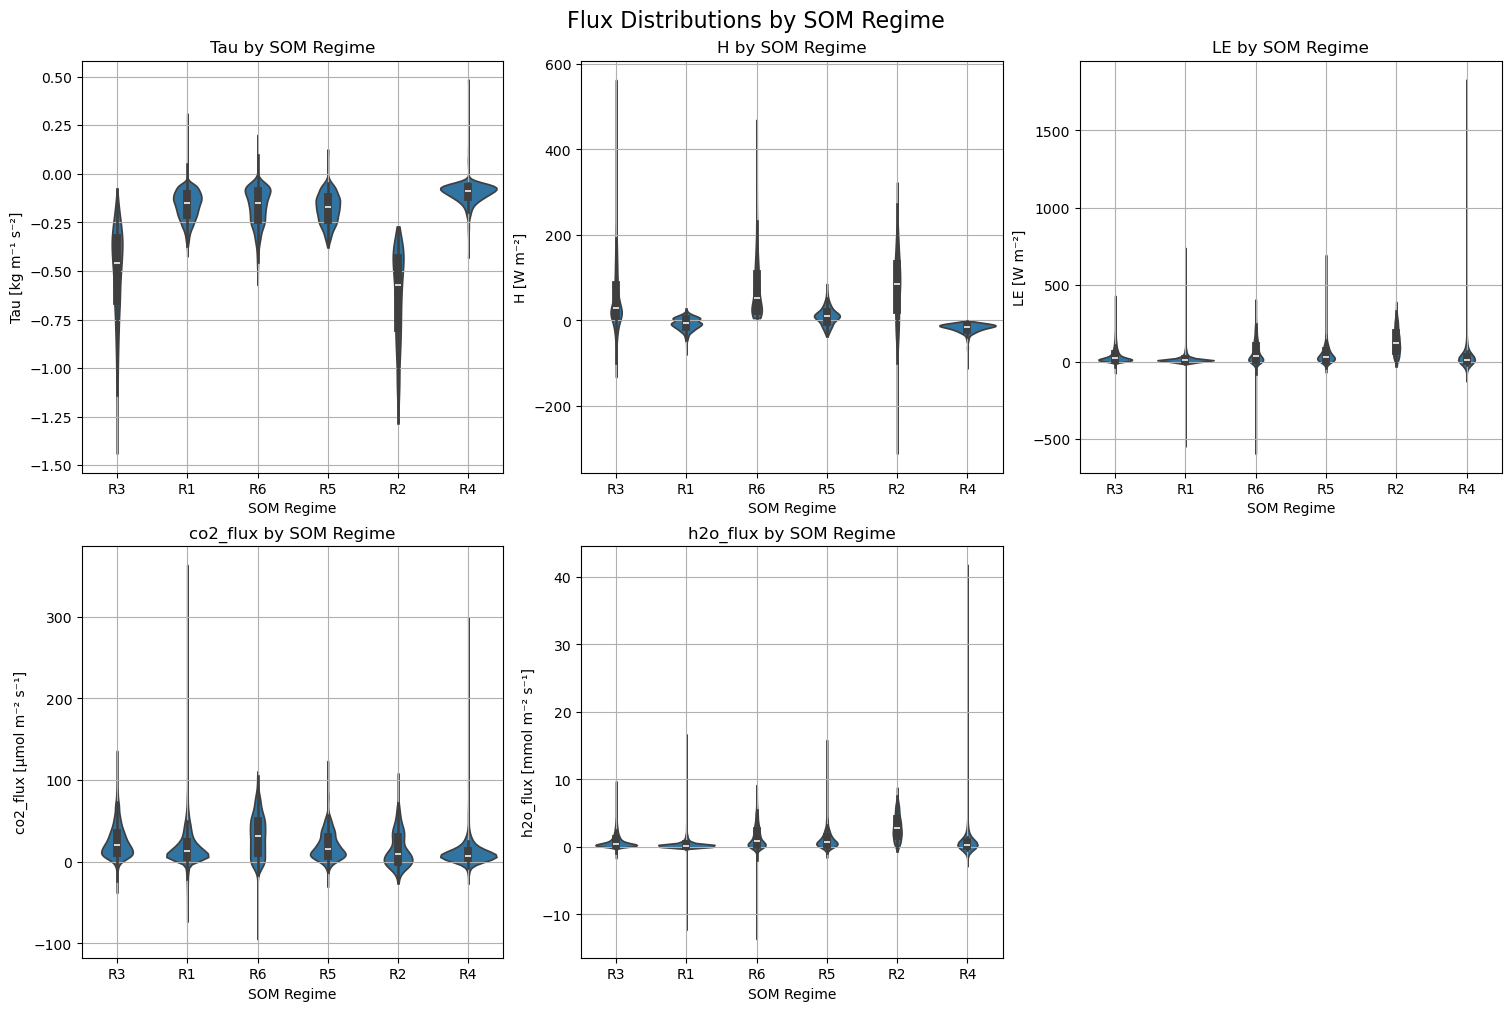

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_18076/119002312.py:45: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/bhupendra/mamba/envs/data/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


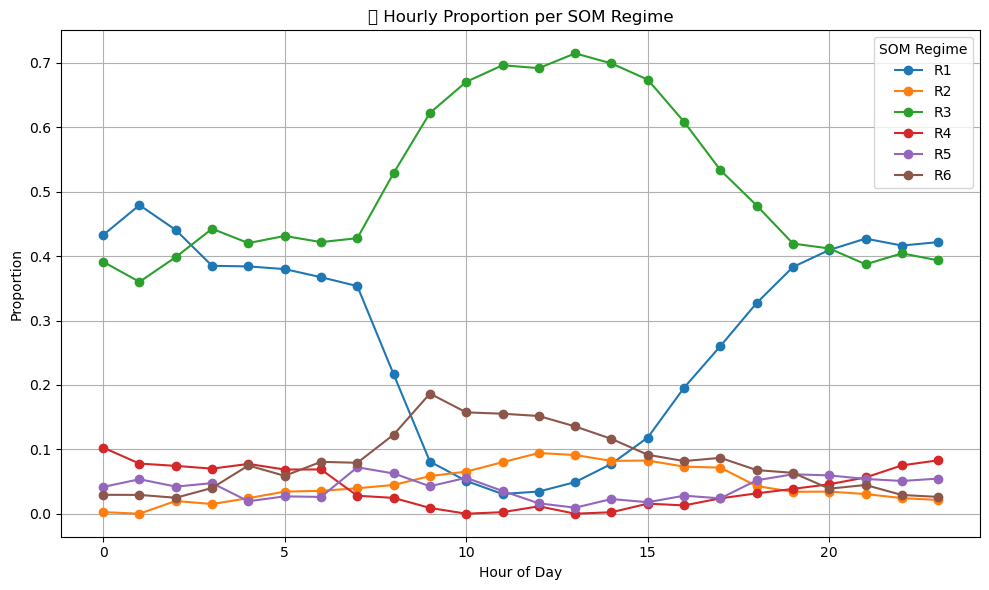

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_18076/119002312.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/bhupendra/mamba/envs/data/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


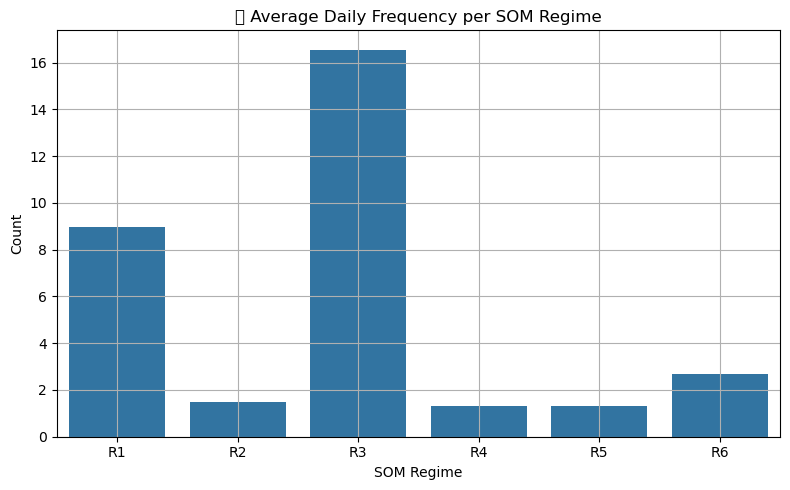

/Users/bhupendra/mamba/envs/data/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


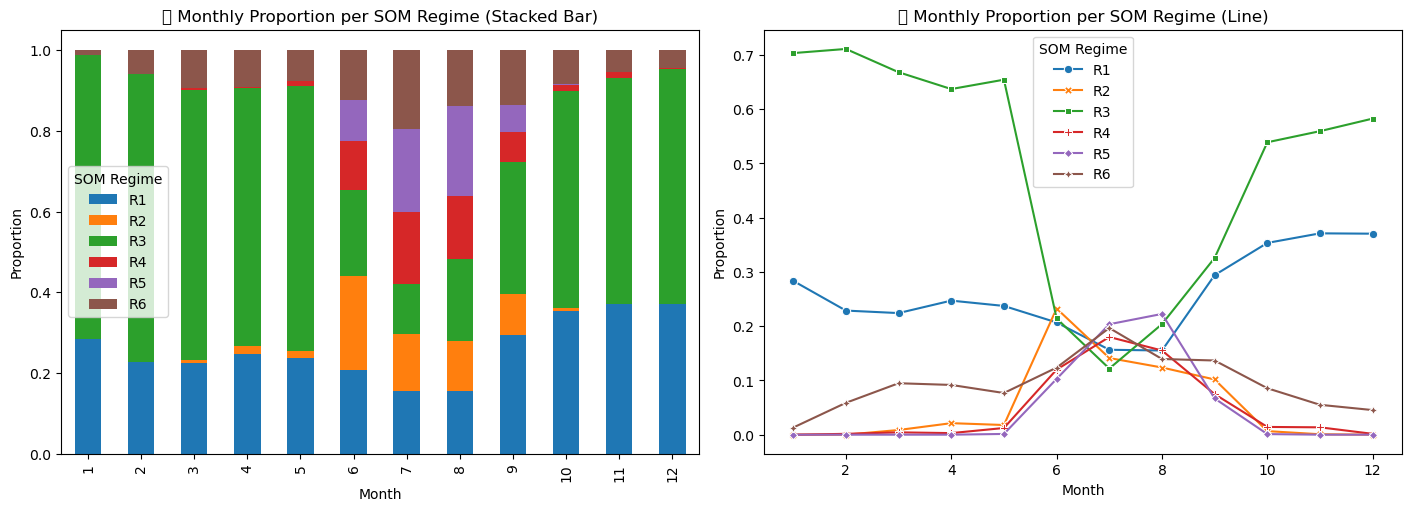

In [7]:
def panel_all_som_cluster_plots(df, cluster_col='som_regime'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    import math

    # Panel 1: Flux Distributions
    flux_vars = ['Tau', 'H', 'LE', 'co2_flux', 'h2o_flux']
    flux_units = {
        'Tau': '[kg m⁻¹ s⁻²]', 'H': '[W m⁻²]', 'LE': '[W m⁻²]',
        'co2_flux': '[μmol m⁻² s⁻¹]', 'h2o_flux': '[mmol m⁻² s⁻¹]'
    }

    n_flux = len(flux_vars)
    cols_flux = 3
    rows_flux = math.ceil(n_flux / cols_flux)
    fig_flux, axs_flux = plt.subplots(rows_flux, cols_flux, figsize=(cols_flux * 5, rows_flux * 5), constrained_layout=True)

    for i, var in enumerate(flux_vars):
        ax = axs_flux[i // cols_flux, i % cols_flux]
        sns.violinplot(data=df, x=cluster_col, y=var, ax=ax, inner='box', cut=0)
        ax.set_title(f'{var} by SOM Regime')
        ax.set_xlabel('SOM Regime')
        ax.set_ylabel(f'{var} {flux_units.get(var, "")}')
        ax.grid(True)

    for j in range(n_flux, rows_flux * cols_flux):
        fig_flux.delaxes(axs_flux[j // cols_flux, j % cols_flux])

    plt.suptitle("Flux Distributions by SOM Regime", fontsize=16)
    plt.show()

    # Panel 2: Hourly Proportion Plot
    hourly = df.groupby(['hour', cluster_col]).size().unstack(fill_value=0)
    hourly_prop = hourly.divide(hourly.sum(axis=1), axis=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    hourly_prop.plot(kind='line', marker='o', ax=ax)
    plt.title("⏰ Hourly Proportion per SOM Regime")
    plt.xlabel("Hour of Day")
    plt.ylabel("Proportion")
    plt.grid(True)
    plt.legend(title='SOM Regime')
    plt.tight_layout()
    plt.show()

    # Panel 3: Daily Count per Regime
    daily = df.groupby(['date', cluster_col]).size().unstack(fill_value=0)
    daily_counts = daily.mean().reset_index()
    daily_counts.columns = [cluster_col, 'Average Daily Count']

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=daily_counts, x=cluster_col, y='Average Daily Count', ax=ax)
    plt.title("📊 Average Daily Frequency per SOM Regime")
    plt.xlabel("SOM Regime")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Panel 4: Monthly Proportion (4-column layout)
    monthly = df.groupby(['month', cluster_col]).size().unstack(fill_value=0)
    monthly_prop = monthly.divide(monthly.sum(axis=1), axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # 4-column version
    monthly_prop.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title("📆 Monthly Proportion per SOM Regime (Stacked Bar)")
    axs[0].set_xlabel("Month")
    axs[0].set_ylabel("Proportion")
    axs[0].legend(title='SOM Regime')

    # 3-column version (lineplot)
    sns.lineplot(data=monthly_prop, dashes=False, markers=True, ax=axs[1])
    axs[1].set_title("📆 Monthly Proportion per SOM Regime (Line)")
    axs[1].set_xlabel("Month")
    axs[1].set_ylabel("Proportion")
    axs[1].legend(title='SOM Regime')

    plt.show()

# Run it
panel_all_som_cluster_plots(df_som, cluster_col='som_regime')


In [8]:
# Re-import required libraries after kernel reset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

# Dummy DataFrame placeholder to avoid execution error since actual df_som is not present
# This would be replaced by actual user data when running locally
# df_som = ...

def panel_all_som_cluster_plots(df, cluster_col='som_regime'):
    flux_vars = ['Tau', 'H', 'LE', 'co2_flux', 'h2o_flux']
    flux_units = {
        'Tau': '[kg m⁻¹ s⁻²]', 'H': '[W m⁻²]', 'LE': '[W m⁻²]',
        'co2_flux': '[μmol m⁻² s⁻¹]', 'h2o_flux': '[mmol m⁻² s⁻¹]'
    }

    n_flux = len(flux_vars)
    cols_flux = 3
    rows_flux = math.ceil(n_flux / cols_flux)
    fig_flux, axs_flux = plt.subplots(rows_flux, cols_flux, figsize=(cols_flux * 5, rows_flux * 5), constrained_layout=True)

    for i, var in enumerate(flux_vars):
        ax = axs_flux[i // cols_flux, i % cols_flux]
        sns.violinplot(data=df, x=cluster_col, y=var, ax=ax, inner='box', cut=0)
        ax.set_title(f'{var} by SOM Regime')
        ax.set_xlabel('SOM Regime')
        ax.set_ylabel(f'{var} {flux_units.get(var, "")}')
        ax.grid(True)

    for j in range(n_flux, rows_flux * cols_flux):
        fig_flux.delaxes(axs_flux[j // cols_flux, j % cols_flux])

    plt.suptitle("Flux Distributions by SOM Regime", fontsize=16)
    plt.show()

    # Panel 2: Hourly Proportion Plot
    hourly = df.groupby(['hour', cluster_col]).size().unstack(fill_value=0)
    hourly_prop = hourly.divide(hourly.sum(axis=1), axis=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    hourly_prop.plot(kind='line', marker='o', ax=ax)
    plt.title("⏰ Hourly Proportion per SOM Regime")
    plt.xlabel("Hour of Day")
    plt.ylabel("Proportion")
    plt.grid(True)
    plt.legend(title='SOM Regime')
    plt.tight_layout()
    plt.show()

    # Panel 3: Daily Count per Regime
    daily = df.groupby(['date', cluster_col]).size().unstack(fill_value=0)
    daily_counts = daily.mean().reset_index()
    daily_counts.columns = [cluster_col, 'Average Daily Count']

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=daily_counts, x=cluster_col, y='Average Daily Count', ax=ax)
    plt.title("📊 Average Daily Frequency per SOM Regime")
    plt.xlabel("SOM Regime")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Panel 4: Monthly Proportion (4-column layout and line version)
    monthly = df.groupby(['month', cluster_col]).size().unstack(fill_value=0)
    monthly_prop = monthly.divide(monthly.sum(axis=1), axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # Stacked bar
    monthly_prop.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title("📆 Monthly Proportion per SOM Regime (Stacked Bar)")
    axs[0].set_xlabel("Month")
    axs[0].set_ylabel("Proportion")
    axs[0].legend(title='SOM Regime')

    # Lineplot
    sns.lineplot(data=monthly_prop, dashes=False, markers=True, ax=axs[1])
    axs[1].set_title("📆 Monthly Proportion per SOM Regime (Line)")
    axs[1].set_xlabel("Month")
    axs[1].set_ylabel("Proportion")
    axs[1].legend(title='SOM Regime')

    plt.show()



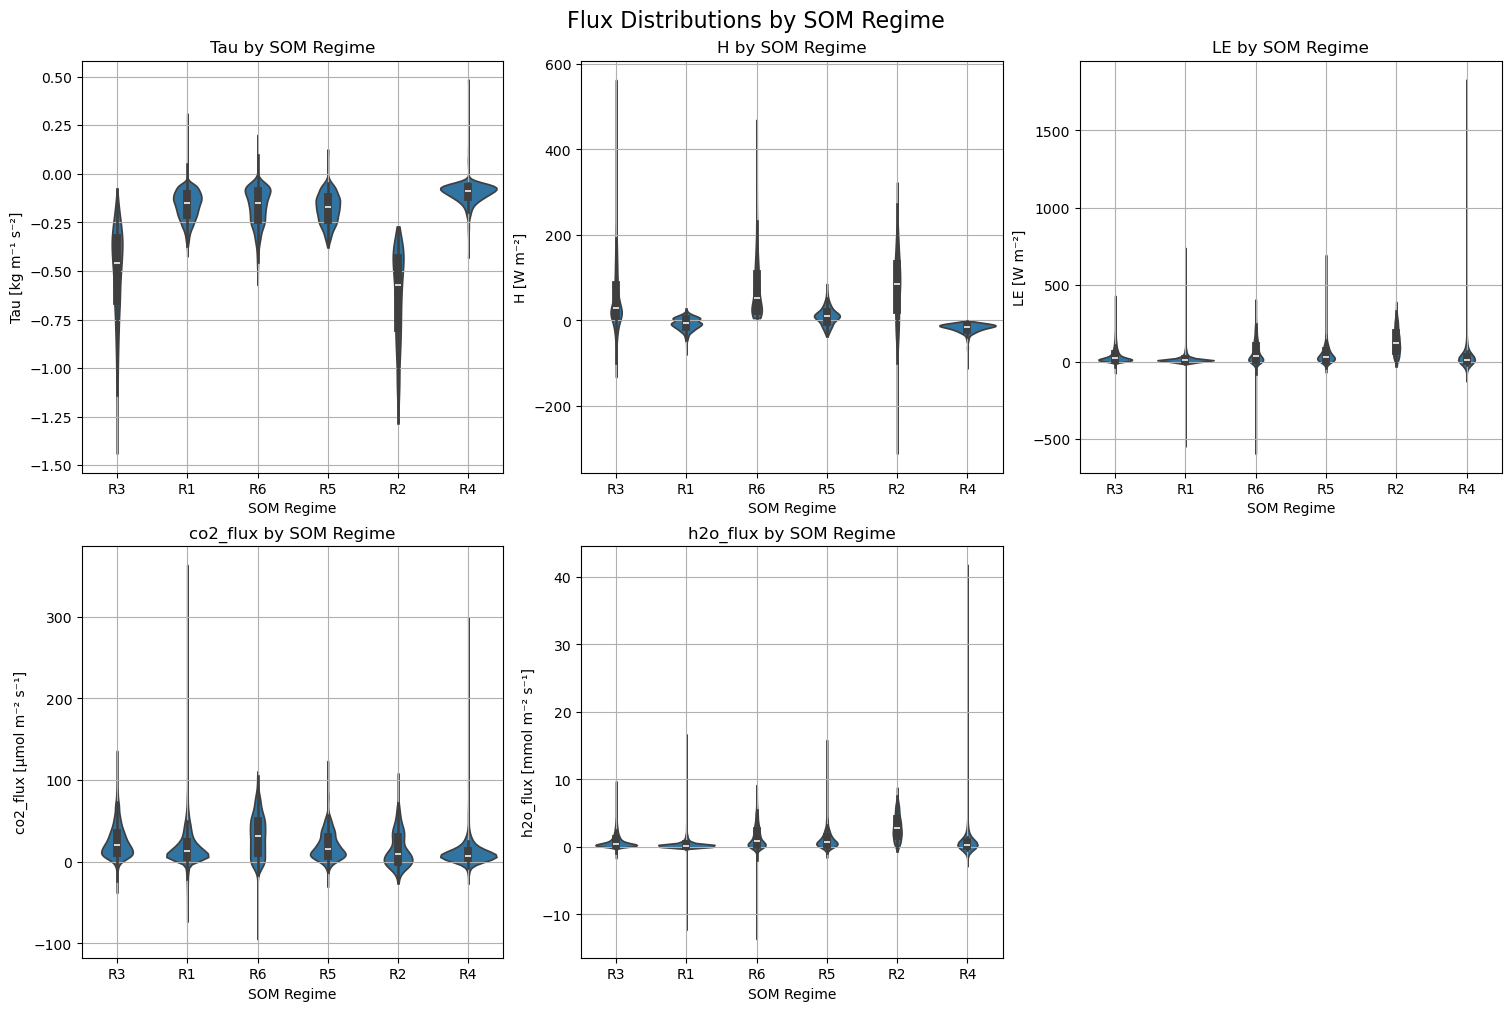

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_18076/1433127456.py:49: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/bhupendra/mamba/envs/data/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


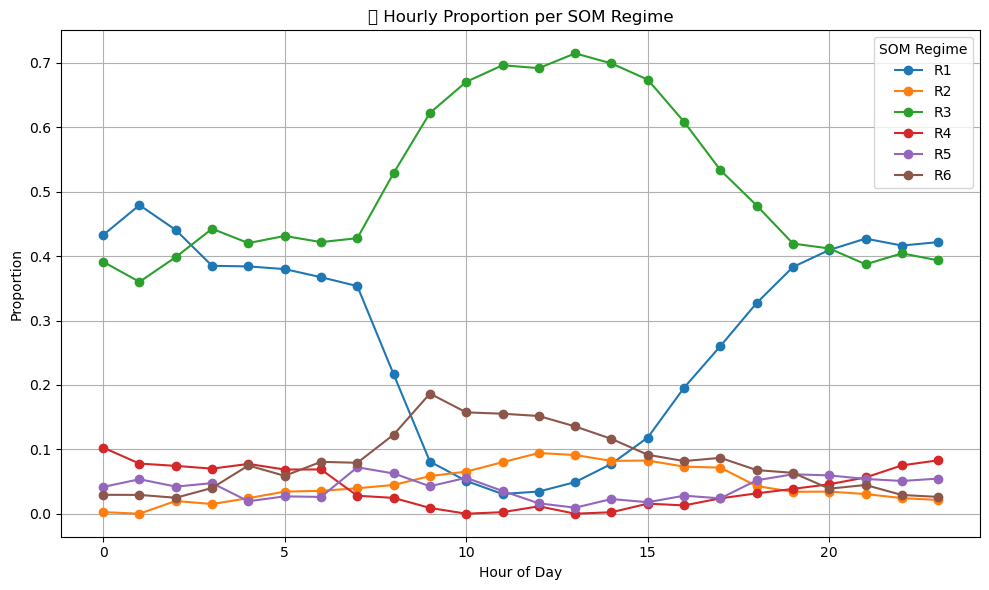

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_18076/1433127456.py:63: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/bhupendra/mamba/envs/data/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


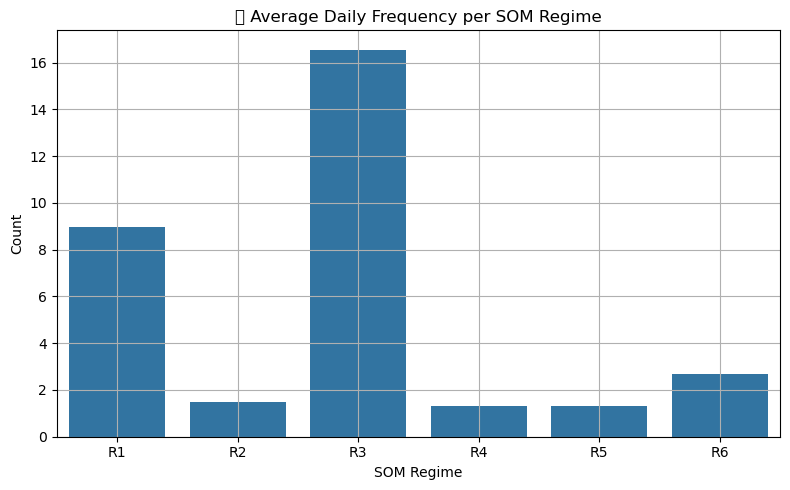

/Users/bhupendra/mamba/envs/data/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


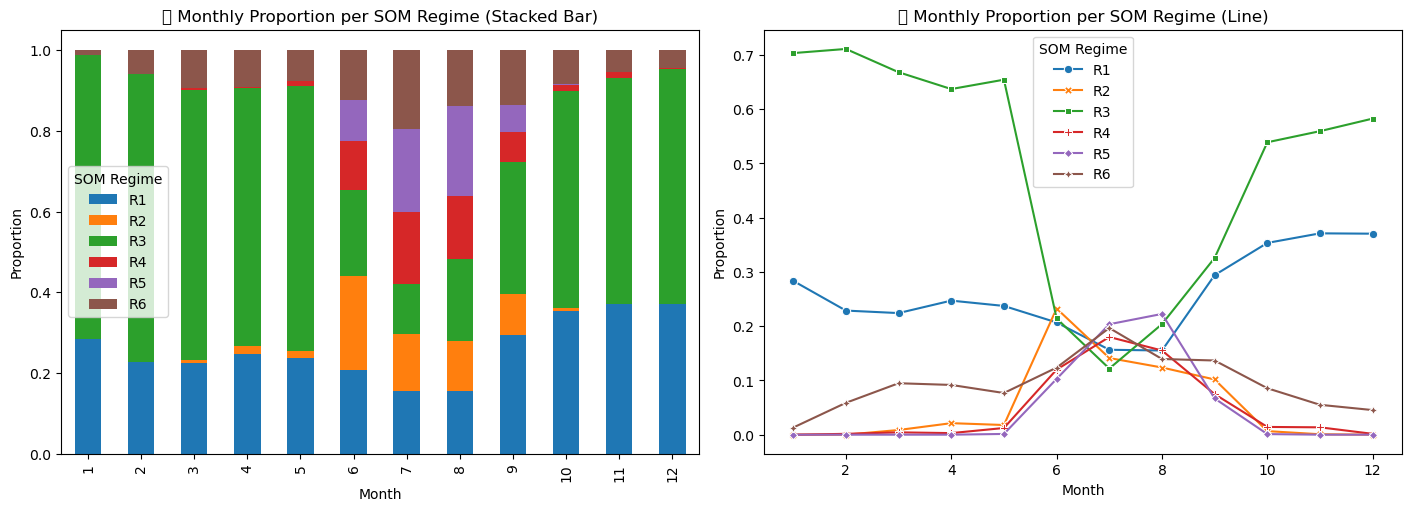

In [9]:
panel_all_som_cluster_plots(df_som, cluster_col='som_regime')


# GMM

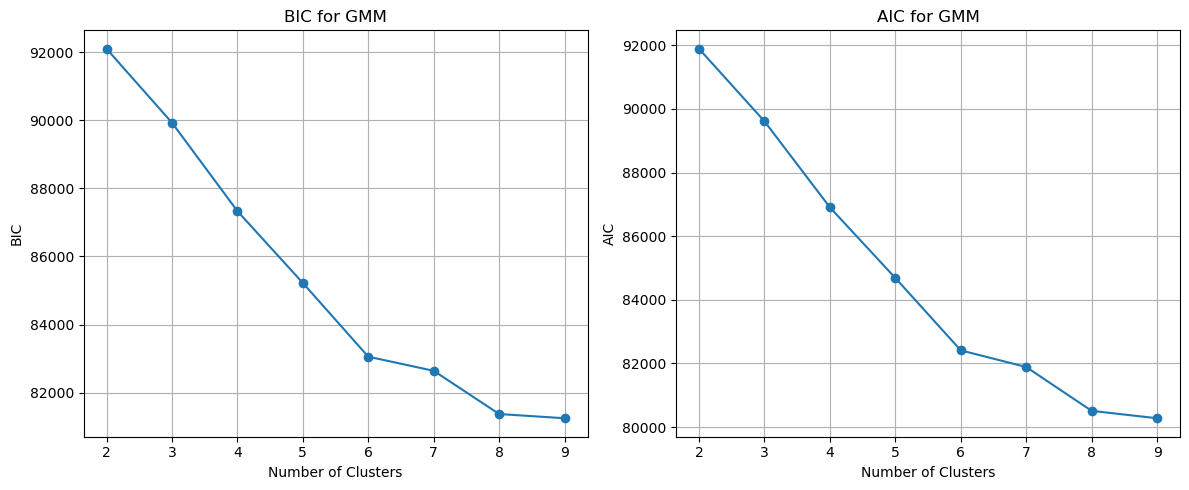

In [10]:
# Re-import necessary packages after kernel reset
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

cluster_vars = ['air_temperature', 'h2o_mixing_ratio', 'u*', 'z_over_L']

# Step 1: Standardize features
X = df_cluster_ready[cluster_vars].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Evaluate GMM for different numbers of clusters using BIC and AIC
n_components_range = range(2, 10)
bics, aics = [], []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

# Plot BIC and AIC
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(n_components_range, bics, marker='o')
ax[0].set_title("BIC for GMM")
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("BIC")
ax[0].grid(True)

ax[1].plot(n_components_range, aics, marker='o')
ax[1].set_title("AIC for GMM")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("AIC")
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [11]:
from sklearn.preprocessing import StandardScaler

def scale_features(df, feature_cols):
    scaler = StandardScaler()
    X = df[feature_cols].values
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

X_scaled, scaler = scale_features(df_cluster_ready, cluster_vars)


In [14]:
from sklearn.mixture import GaussianMixture

def assign_gmm_clusters(df, X_scaled, n_clusters=6, label='GMM_regime'):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    df_labeled = df.copy()
    df_labeled[label] = labels + 1  # start labels from 1
    return df_labeled, gmm

df_gmm_clustered, gmm_model = assign_gmm_clusters(df_cluster_ready, X_scaled, n_clusters=6)


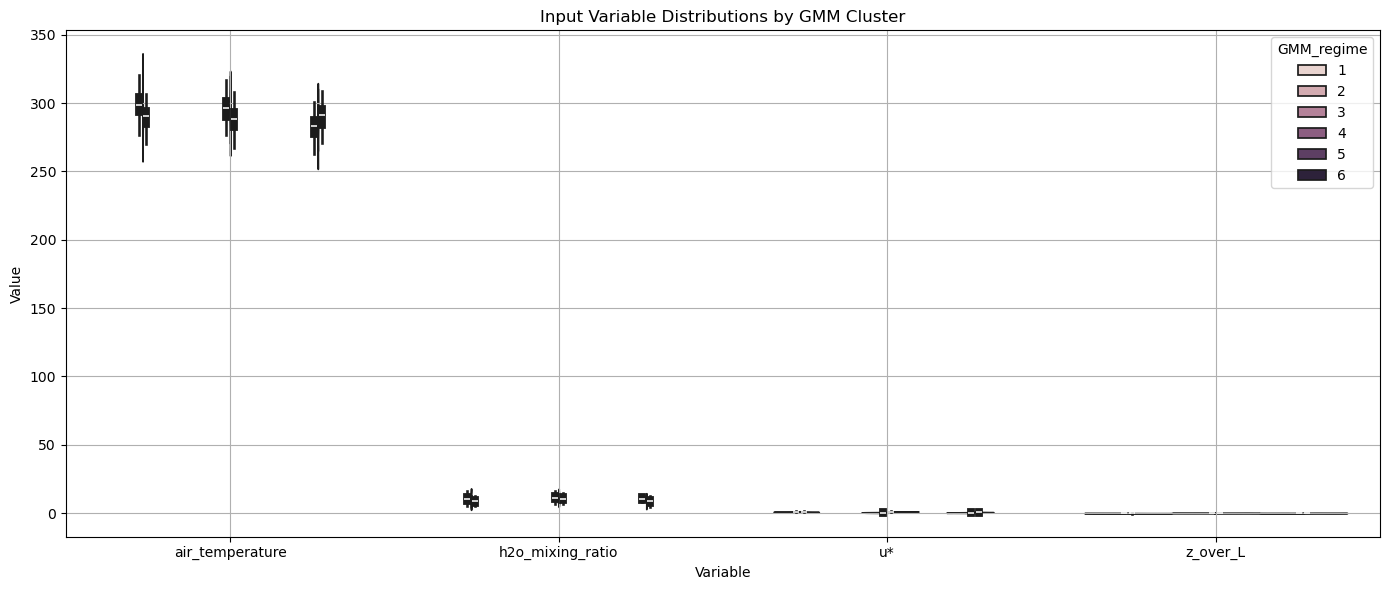

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_18076/1494031794.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/bhupendra/mamba/envs/data/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


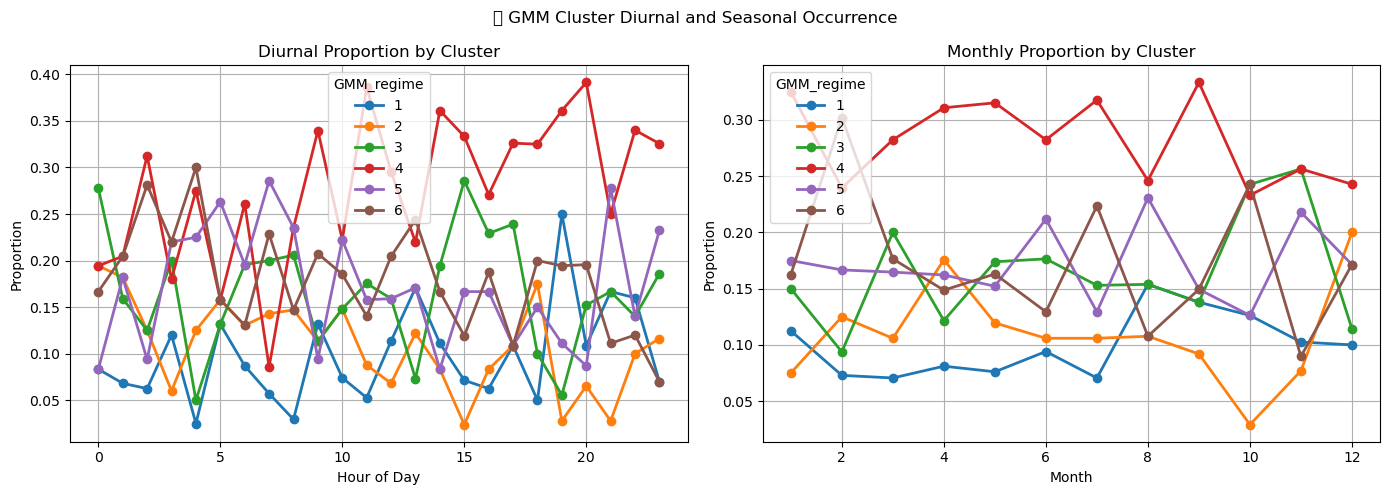

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Simulate clustered dataset for demonstration
np.random.seed(42)
size = 1000
df_cluster_ready = pd.DataFrame({
    'air_temperature': np.random.normal(290, 10, size),
    'h2o_mixing_ratio': np.random.normal(10, 2, size),
    'u*': np.random.uniform(0.2, 1.2, size),
    'z_over_L': np.random.normal(0, 0.1, size),
    'hour': np.random.randint(0, 24, size),
    'month': np.random.randint(1, 13, size)
})

# Step 1: Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_ready[['air_temperature', 'h2o_mixing_ratio', 'u*', 'z_over_L']])

# Step 2: GMM clustering
gmm = GaussianMixture(n_components=6, random_state=42)
labels = gmm.fit_predict(X_scaled)
df_cluster_ready['GMM_regime'] = labels + 1

# Plot distributions of input features by cluster
melted = df_cluster_ready.melt(id_vars='GMM_regime', 
                                value_vars=['air_temperature', 'h2o_mixing_ratio', 'u*', 'z_over_L'],
                                var_name='Variable', value_name='Value')
plt.figure(figsize=(14, 6))
sns.violinplot(data=melted, x='Variable', y='Value', hue='GMM_regime', split=True)
plt.title('Input Variable Distributions by GMM Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot diurnal and seasonal cluster proportions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

hourly = df_cluster_ready.groupby(['hour', 'GMM_regime']).size().unstack(fill_value=0)
hourly = hourly.divide(hourly.sum(axis=1), axis=0)
hourly.plot(ax=axes[0], marker='o', linewidth=2)
axes[0].set_title("Diurnal Proportion by Cluster")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Proportion")
axes[0].grid(True)

monthly = df_cluster_ready.groupby(['month', 'GMM_regime']).size().unstack(fill_value=0)
monthly = monthly.divide(monthly.sum(axis=1), axis=0)
monthly.plot(ax=axes[1], marker='o', linewidth=2)
axes[1].set_title("Monthly Proportion by Cluster")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Proportion")
axes[1].grid(True)

plt.suptitle("📊 GMM Cluster Diurnal and Seasonal Occurrence")
plt.tight_layout()
plt.show()
